In [1]:
import numpy as np
import networkx as nx
import matplotlib.pylab as plt
%matplotlib inline
import os
import math
import pandas as pd
from scipy import optimize

# Leo las redes

In [2]:
def ldata(archive):
    f=open(archive)
    data=[]
    for line in f:
        line=line.strip()
        col=line.split()
        data.append(col)
    return data

Y2H=ldata('yeast_Y2H.txt')
LIT=ldata('yeast_LIT.txt')
LIT_R=ldata('yeast_LIT_Reguly.txt')


def grafo(datosRed):
    G = nx.Graph()
    for i in range(np.shape(datosRed)[0]):
        G.add_edges_from([(datosRed[i][0],datosRed[i][1])])
    return G

GY2H=grafo(Y2H)
GLIT=grafo(LIT)
GLIT_R=grafo(LIT_R)

ESENCIALIDAD DE LOS NODOS

In [3]:
essentiality=ldata('Essential.txt')

ess=[]
for i in range(len(essentiality)):
    ess.append(essentiality[i][1])
    
def essentiality(nodo): 
    if len({nodo}.intersection(set(ess)))==0:
        e=0
    else:
        e=1
    return e    

def AssignEssentiality(G):
    dict_ess = { nodo: essentiality(nodo) for nodo  in G.nodes() }
    for n in G.nodes:
        G.nodes[n]["essentiality"] = dict_ess[n]
    return

def NodosEsenciales(G):
    AssignEssentiality(G)
    nodosesenciales=[]
    for nodo in list(set(G.nodes())):
        if G.nodes.data("essentiality")[nodo]==1:
            nodosesenciales.append(nodo)
    return(nodosesenciales)

# i) Fraccion de nodos esenciales por grado

In [4]:
def fracessk(G):
    
    deg=[degree for node,degree in list(G.degree())]
    deg=list(set(deg))
    listin=[[degree,name] for (name, degree) in list(G.degree())]
    nodosesenciales=NodosEsenciales(G)
    ntot=np.zeros(len(deg),dtype=int)
    ness=np.zeros(len(deg),dtype=int)
    index=0

    for k in deg:
        for i in range(len(listin)):
            if listin[i][0]==k:
                ntot[index]=ntot[index]+1
                
                if (len({listin[i][1]}.intersection(set(nodosesenciales)))==1):
                    ness[index]=ness[index]+1    
        index=index+1    
    
    fraccion_nodos_ess=ness/ntot
    deg_array=np.array(deg)
    ntot=np.array(ntot)
    
    return deg_array,ntot,fraccion_nodos_ess

In [5]:
degrees_Y2H,ntot_Y2H,frac_Y2H=fracessk(GY2H)
degrees_LIT,ntot_LIT,frac_LIT=fracessk(GLIT)
degrees_LIT_R,ntot_LIT_R,frac_LIT_R=fracessk(GLIT_R)

¿Hasta que k tengo que llegar para tener el 95% de los nodos de la red?

In [6]:
def idegree_max(ntot):
    
    Nsum=0
    Ncrit=int(0.95*ntot_Y2H.sum())
    
    for i in range(len(ntot_Y2H)):
        if Nsum>= Ncrit:
            icrit=i
            break
        else:
            Nsum=Nsum+ntot_Y2H[i]
            
    return icrit

In [7]:
id_Y2H=idegree_max(ntot_Y2H)
id_LIT=idegree_max(ntot_LIT)
id_LIT_R=idegree_max(ntot_LIT_R)

In [8]:
print(id_APMS,id_Y2H,id_LIT,id_LIT_R)

8 8 8 8


# AJUSTE LINEAL

In [10]:
x_Y2H=degrees_Y2H[0:10]
y_Y2H=np.log(1-frac_Y2H[0:10])

x_LIT=degrees_LIT[0:10]
y_LIT=np.log(1-frac_LIT[0:10])

x_LIT_R=degrees_LIT_R[0:10]
y_LIT_R=np.log(1-frac_LIT_R[0:10])

In [11]:
def linearfit(X,Y):
    
    fitfunc = lambda p, x: p[0] + p[1] * x
    errfunc = lambda p, x, y: (y - fitfunc(p, x))
    pinit = [1.0, -1.0]
    out = optimize.leastsq(errfunc, pinit,args=(X, Y), full_output=1)
    
    b=out[0][0]
    m=out[0][1]
    covar=out[1]
    
    s_sq = ( ( Y- ( m*X + b ) )**2 ).sum() / (len(X))
    b_err=np.sqrt(s_sq*covar[0][0])
    m_err=np.sqrt(s_sq*covar[1][1])
    
    M=np.array([m,m_err])
    B=np.array([b,b_err])
    
    return M,B

In [30]:
M_Y2H,B_Y2H=linearfit(x_Y2H,y_Y2H)
M_LIT,B_LIT=linearfit(x_LIT,y_LIT)
M_LIT_R,B_LIT_R=linearfit(x_LIT_R,y_LIT_R)

In [15]:
m_Y2H, b_Y2H = M_Y2H[0],B_Y2H[0]
m_LIT, b_LIT = M_LIT[0],B_LIT[0]
m_LIT_R, b_LIT_R = M_LIT_R[0],B_LIT_R[0]

alpha_Y2H=1-np.exp(m_Y2H)
beta_Y2H=1-np.exp(b_Y2H)

alpha_LIT=1-np.exp(m_LIT)
beta_LIT=1-np.exp(b_LIT)

alpha_LIT_R=1-np.exp(m_LIT_R)
beta_LIT_R=1-np.exp(b_LIT_R)

ERROR ALPHA Y BETA

In [55]:
def err_alpbet(m,b,err_m,err_b):
    
    dalpha_dm=m*np.exp(m)
    alpha_err= dalpha_dm * err_m
    
    dbeta_db=b*np.exp(b)
    beta_err= dbeta_db * err_b
    
    return np.abs(alpha_err), np.abs(beta_err)

In [56]:
alpha_err_Y2H, beta_err_Y2H = err_alpbet(m_Y2H,b_Y2H,M_Y2H[1],B_Y2H[1])
alpha_err_LIT, beta_err_LIT = err_alpbet(m_LIT,b_LIT,M_LIT[1],B_LIT[1])
alpha_err_LIT_R, beta_err_LIT_R = err_alpbet(m_LIT_R,b_LIT_R,M_LIT_R[1],B_LIT_R[1])

In [110]:
print('ALPHA_Y2H:', alpha_Y2H,'+/-',alpha_err_Y2H)
print('BETA_Y2H:', beta_Y2H,'+/-',beta_err_Y2H)
print()
print('ALPHA_LIT:', alpha_LIT,'+/-',alpha_err_LIT)
print('BETA_LIT:', beta_LIT,'+/-',beta_err_LIT)
print()
print('ALPHA_LIT_R:', alpha_LIT_R,'+/-',alpha_err_LIT_R)
print('BETA_LIT_R:', beta_LIT_R,'+/-',beta_err_LIT_R)

ALPHA_Y2H: 0.0146558606277 +/- 0.000141801291586
BETA_Y2H: 0.182168183614 +/- 0.00994677224064

ALPHA_LIT: 0.063560866823 +/- 0.000846012408875
BETA_LIT: 0.299932483424 +/- 0.0213083890701

ALPHA_LIT_R: 0.0527767347068 +/- 0.000272238450382
BETA_LIT_R: 0.0427113454674 +/- 0.0013743412248


PLOT

In [17]:
yfit_Y2H=m_Y2H*degrees_Y2H[0:10]+b_Y2H
yfit_LIT=m_LIT*degrees_LIT[0:10]+b_LIT
yfit_LIT_R=m_LIT_R*degrees_LIT_R[0:10]+b_LIT_R

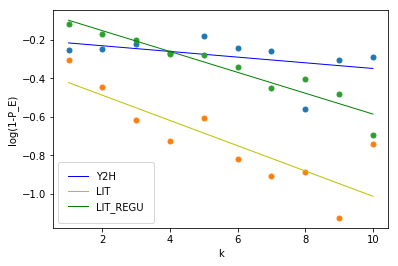

In [18]:
plt.plot(degrees_Y2H[0:10],np.log(1-frac_Y2H[0:10]),'.', markersize=10)
plt.plot(degrees_Y2H[0:10],yfit_Y2H,'b',linewidth=1,label='Y2H')
plt.plot(degrees_LIT[0:10],np.log(1-frac_LIT[0:10]),'.', markersize=10)
plt.plot(degrees_LIT[0:10],yfit_LIT,'y',linewidth=1,label='LIT')
plt.plot(degrees_LIT_R[0:10],np.log(1-frac_LIT_R[0:10]),'.', markersize=10)
plt.plot(degrees_LIT_R[0:10],yfit_LIT_R,'g',linewidth=1,label='LIT_REGU')

plt.xlabel('k')
plt.ylabel('log(1-P_E)')
plt.legend(borderpad=1)

# ii) cuantos pares de nodos con al menos 3 vecinos en comun y no enlazados

In [104]:
def TotalYFraccionPares(G,Nvecinos):
    nodes=list(G.nodes())
    N=len(G.nodes())
    A=nx.to_numpy_matrix(G)
    Acuadrado=np.matmul(A,A)
    ParesTotal=[]
    for i in range(N):
        for j in range(i+1,N):
            if (A[i,j]==0 and Acuadrado[i,j]>=Nvecinos):
                ParesTotal.append([nodes[i],nodes[j]])
    Numero_Pares_Total=len(ParesTotal)
    
    nodosesenciales=NodosEsenciales(G)
    ParesIguales=[]
    
    for i in range(Numero_Pares_Total):
        if ( len({ParesTotal[i][0]}.intersection(set(nodosesenciales)))==1 and len({ParesTotal[i][1]}.intersection(set(nodosesenciales)))==1):
            ParesIguales.append(ParesTotal[i])
        if ( len({ParesTotal[i][0]}.intersection(set(nodosesenciales)))==0 and len({ParesTotal[i][1]}.intersection(set(nodosesenciales)))==0):
            ParesIguales.append(ParesTotal[i])
    
    Numero_Pares_Iguales=len(ParesIguales)
    
    return(ParesTotal,Numero_Pares_Total,Numero_Pares_Iguales)

In [105]:
ParesTotalY2H,NumeroParesTotalY2H,NumeroParesIgualesY2H=TotalYFraccionPares(GY2H,2)
ParesTotalLIT,NumeroParesTotalLIT,NumeroParesIgualesLIT=TotalYFraccionPares(GLIT,2)
ParesTotalLIT_R,NumeroParesTotalLIT_R,NumeroParesIgualesLIT_R=TotalYFraccionPares(GLIT_R,3)

AHORA CALCULO LA PROBABILIDAD CON EL ALPHA Y EL BETA

$$P_E= 1-(1-\alpha)^k (1-\beta)$$

In [25]:
def ParesEsperados(G,ParesTotal,alpha,beta):
    degree=dict(G.degree())
    
    ParesDegree=[]
    for i in range(len(ParesTotal)):
        ParesDegree.append([degree[ParesTotal[i][0]],degree[ParesTotal[i][1]]])
    
    PD=np.array(ParesDegree)
    PE=1-(1-alpha)**PD *(1-beta)
    PNE=1-PE #jaja

    Pares_esperados= (PE[:,0]*PE[:,1]).sum() + (PNE[:,0]*PNE[:,1]).sum()
    
    return Pares_esperados

In [26]:
expectedY2H=int(ParesEsperados(GY2H,ParesTotalY2H,alpha_Y2H,beta_Y2H))
expectedLIT=int(ParesEsperados(GLIT,ParesTotalLIT,alpha_LIT,beta_LIT))
expectedLIT_R=int(ParesEsperados(GLIT_R,ParesTotalLIT_R,alpha_LIT_R,beta_LIT_R))

In [27]:
expectedY2H,expectedLIT,expectedLIT_R

(6430, 1307, 961, 5779)

ERRORES PARES ESPERADOS

In [87]:
def err_Nexp(G,ParesTotal,alpha,beta,err_alpha,err_beta):
    
    degree=dict(G.degree())
    ParesDegree=[]
    
    for i in range(len(ParesTotal)):
        ParesDegree.append([degree[ParesTotal[i][0]],degree[ParesTotal[i][1]]])
    
    PD=np.array(ParesDegree)
    
    ta_i=PD[:,0]*((1-alpha)**(PD[:,0]-1))
    ta_j=PD[:,1]*((1-alpha)**(PD[:,1]-1))
    ta_ij=-2*((PD[:,0]+PD[:,1])* (1-alpha)**(PD[:,0]+PD[:,1]-1))*(1-beta)**2
    dN_da=ta_i.sum()+ta_j.sum()+ta_ij.sum()
    
    tb_i=(1-alpha)**(PD[:,0])
    tb_j=(1-alpha)**(PD[:,1])
    tb_ij=-4*((1-alpha)**(PD[:,0]+PD[:,1]))*(1-beta)
    dN_db=tb_i.sum()+tb_j.sum()+tb_ij.sum()
    
    err_N=np.sqrt((dN_da*err_alpha)**2+(dN_db*err_beta)**2)
    
    return int(err_N)

In [92]:
err_NY2H=err_Nexp(GY2H,ParesTotalY2H,alpha_Y2H,beta_Y2H,alpha_err_Y2H,beta_err_Y2H)
err_NLIT=err_Nexp(GLIT,ParesTotalLIT,alpha_LIT,beta_LIT,alpha_err_LIT,beta_err_LIT)
err_NLIT_R=err_Nexp(GLIT_R,ParesTotalLIT_R,alpha_LIT_R,beta_LIT_R,alpha_err_LIT_R,beta_err_LIT_R)

# RESULTADOS

In [102]:
 from IPython.display import HTML, display

 data = [["RED","PARES TOTALES","PARES DEL MISMO TIPO","PARES ESPERADOS", "ERROR"],
         ["Y2H",NumeroParesTotalY2H, NumeroParesIgualesY2H, expectedY2H,err_NY2H],
         ["LIT",NumeroParesTotalLIT,NumeroParesIgualesLIT,expectedLIT,err_NLIT],
         ["LIT_R",NumeroParesTotalLIT_R, NumeroParesIgualesLIT_R, expectedLIT_R,err_NLIT ],
         ]

 display(HTML(
    '<table><tr>{}</tr></table>'.format(
        '</tr><tr>'.join(
            '<td>{}</td>'.format('</td><td>'.join(str(_) for _ in row)) for row in data)
        )
 ))

RED,PARES TOTALES,PARES DEL MISMO TIPO,PARES ESPERADOS,ERROR
Y2H,2258,1514,1307,15
LIT,1858,1047,961,8
LIT_R,10777,6187,5779,8
